In [2]:
#Importing Data from the CSV file
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import seaborn as sns
import time
from scipy import spatial
from itertools import combinations 
import pickle

28*28 - one row size = 784 - one training data

In [3]:
def input_read(file, sep, class0=None, class1=None):
    myFile = pd.read_csv(file, sep=sep, header=None, index_col=False)
    if ((class0!=None) and (class1!=None)):
        df_train = myFile[(myFile.get(784) == class0) | (myFile.get(784) == class1)]
    elif ((class0!=None) and (class1==None)):
        df_train = myFile
    else: df_train = myFile
    train_classes = df_train[784]
    if ((class0!=None) and (class1!=None)):
        train_classes = (train_classes.apply(lambda x: 1 if (x==class1) else -1))*1.
    elif ((class0!=None) and (class1==None)):
        train_classes = (train_classes.apply(lambda x: 1 if (x==class0) else -1))*1.
    train_classes.index = np.arange(0, len(df_train))
    df_train = df_train.drop(784, axis=1)
    df_train.index=(np.arange(0, len(df_train)))
    df_train /= 255
    return df_train.to_numpy(), train_classes.to_numpy();

In [4]:
def calc_accuracy(classes, pred_classes):   
    acc = 0
    for i in range(len(classes)):
        if (classes[i]==pred_classes[i]):
            acc+=1
    acc = (acc/len(classes))*100
    return acc

# Implementation using SVM Classifier

# Read whole input training set for SVM classifier

In [7]:
X_train, train_classes = input_read('fashion_mnist/train.csv', ',')
X_val, val_classes = input_read('fashion_mnist/val.csv', ',')
X_test, test_classes = input_read('fashion_mnist/test.csv', ',')

In [8]:
def sklearn_svm(X_train, train_classes, shape, gamma='scale'):
    start = time.time()
    svc_classifier = svc(kernel=shape, gamma=gamma, probability=True)
    svc_classifier.fit(X_train, train_classes)
    train_pred_svc = svc_classifier.predict_proba(X_train)
    val_pred_svc = svc_classifier.predict_proba(X_val)
    test_pred_svc = svc_classifier.predict_proba(X_test)
    train_acc_svc = svc_classifier.score(X_train, train_classes)
    val_acc_svc = svc_classifier.score(X_val, val_classes)
    test_acc_svc = svc_classifier.score(X_test, test_classes)
    print("The time taken to train SVM model using SVM classifier SKLEARN and {} Kernel = {}sec"
          .format(shape, time.time()-start))    
    print("The number of support vectors in SVM classifier trained model with {} kernel = {}"
          .format(shape, svc_classifier.n_support_))
    return train_pred_svc, val_pred_svc, test_pred_svc, train_acc_svc, val_acc_svc, test_acc_svc;

In [9]:
print("\n\nRunning SVM Classifier from SKLEARN to classify with Gaussian Kernel with OVR")
print("--------------------TRAINING--------------------------------------------")
train_pred_svc, val_pred_svc, test_pred_svc, train_acc_svc, val_acc_svc, test_acc_svc= sklearn_svm(X_train, train_classes, 'rbf', 0.05)

val_label_pred_svc = [np.where(x == max(x))[0][0] for x in val_pred_svc[:,:]]
test_label_pred_svc  = [np.where(x == max(x))[0][0] for x in test_pred_svc[:,:]]
val_acc = calc_accuracy(val_classes, val_label_pred_svc)
test_acc = calc_accuracy(test_classes, test_label_pred_svc)

print("-----------SVM classifier--------------")

#print("The number of support vectors are = {}".format())
print("The training accuracy of the SVM model is = {:2.3f}%".format(train_acc_svc*100))
print("The Validation accuracy of the SVM model is= {:2.3f}%".format(val_acc))
print("The test accuracy of the SVM model is = {:2.3f}%".format(test_acc))



Running SVM Classifier from SKLEARN to classify with Gaussian Kernel with OVR
--------------------TRAINING--------------------------------------------
The time taken to train SVM model using SVM classifier SKLEARN and rbf Kernel = 1711.1470119953156sec
The number of support vectors in SVM classifier trained model with rbf kernel = [1291  368 1543 1144 1541 1282 1832  770 1078  816]
-----------SVM classifier--------------
The training accuracy of the SVM model is = 96.920%
The Validation accuracy of the SVM model is= 88.120%
The test accuracy of the SVM model is = 88.100%


In [14]:
def plot_conf_matrix(kernel_shape, test_classes, test_pred_svc ):
    print("\nPlotting Confusion Matrix for {} Kernel - CVXOPT vs. SVMC-library".format(kernel_shape))

    conf_matrix_svmC = confusion_matrix(test_classes, test_pred_svc)

    fig1 = plt.figure(1)
    ax1 = fig1.add_subplot(111)
    sns.heatmap(conf_matrix_svmC, annot=True, ax = ax1, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
    #ax1.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
    ax1.set_ylabel('Actual labels');
    ax1.set_xlabel('Predicted labels'); 
    ax1.set_title('Confusion Matrix with SVM-C-OVR'); 
    #ax1.xaxis.set_ticklabels(['y=0', 'y=1']); ax1.yaxis.set_ticklabels(['y=0', 'y=1']);

    fig1.tight_layout(pad=3.0)
    fig1.savefig('3b_cm_svm_test_multiclass_ovr.png', dpi=1000, bbox_inches='tight')
    
    #plt.show()


Plotting Confusion Matrix for gaussian Kernel - CVXOPT vs. SVMC-library


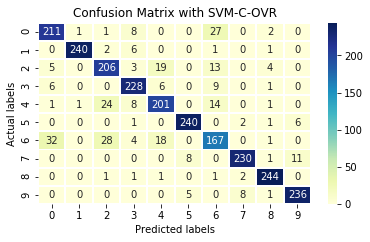

In [13]:
plot_conf_matrix('gaussian', val_classes, val_label_pred_svc)


Plotting Confusion Matrix for gaussian Kernel - CVXOPT vs. SVMC-library


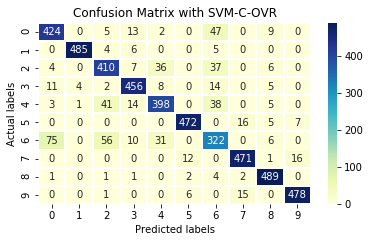

In [15]:
plot_conf_matrix('gaussian', test_classes, test_label_pred_svc)